# Representation of signals & inverse problems - G1-G2
---
## Lab 2: Wavelet transform and image processing

**Objective**: this lab explores some aspects of orthogonal wavelet transforms in 2D for image processing, with applications to denoising and filtering. All the numerical illustrations covered in this session rely on the Python module `Pywavelets`.

Each wavelet is determined by its low-pass filter or scaling function (in french _fonction d'échelle_). The longer this filter (*i.e.*, the more coefficients it contains), the larger the number of null moments. For instance, Daubechies wavelets are composed of $p=2k$ coefficients, for $k$ null moments.

A larger number of null moments allows regular signals/images to be better compressed. However, an extended support of the wavelet can be problematic to represent highly irregular regions of the signal, such as discontinuities.

The choice of a wavelet is a matter of compromise, depending on the type of structures expected to be observed in the image of interest.

**PyWavelets** is an open source wavelet transform package for Python. It combines a simple high level interface with low level C and Cython performance.

In [ ]:
%pip install pywavelets

## Configuration

In [ ]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots (one of the options below)
# %matplotlib widget
%matplotlib inline
# %matplotlib notebook

In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pylab
import matplotlib.image as mpimg

from scipy.signal import *
from scipy.stats import *
from scipy.io.wavfile import *
from scipy.io import *
from numpy.fft import *
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from matplotlib.colors import LogNorm  # for Log normalization

# to install the sounddevice library: type the following code in Anacoda command prompt: conda install sounddevice
import sounddevice as sd
from IPython.display import Audio

#from lib.module_TDS import *
#from lib.plotwavelet import *

>[Representation of signals & inverse problems - G1-G2](#scrollTo=rm_NNHNFPPD6)

>>[Lab 2: Wavelet transform and image processing](#scrollTo=rm_NNHNFPPD6)

>>[Configuration](#scrollTo=kxtiCnfsPPD8)

>>[1D discrete wavelet transform  (↑)](#scrollTo=mO7i9f1uPPD-)

>>>>[Computing your first orthogonal wavelet transform](#scrollTo=DxgI_zfAPPD_)

>>>[Exercise 1  (↑)](#scrollTo=AHedAVofPPEB)

>>[2D discrete wavelet transform  (↑)](#scrollTo=j1B_OoFQPPEC)

>>>>[Wavelet transform](#scrollTo=tooCT8eWPPED)

>>>[Exercise 2  (↑)](#scrollTo=q_5VlOqAPPEE)

>>[Wavelet filtering  (↑)](#scrollTo=982wEcGjPPEE)

>>>>[First steps for filtering](#scrollTo=skEl44hoPPEF)

>>>[Exercise 3  (↑)](#scrollTo=HnCssfY8PPEG)

>>[Wavelet Denoising  (↑)](#scrollTo=Hau6I9MwPPEH)

>>>>[Peak signal-to-noise ratio: definition](#scrollTo=5-LLgmvqPPEH)

>>>>[Thresholding](#scrollTo=nTzSo3p7PPEI)

>>>>[Reconstruction](#scrollTo=tP-32iUtPPEJ)

>>>[Exercise 4  (↑)](#scrollTo=H0HUqzu-PPEK)



---
## 1D discrete wavelet transform <a id="section1"></a> [(&#8593;)](#content)
The Discrete Wavelet Transform (DWT) of a signal can be computed with the `pywt.dwt` and `pywt.wavedec` functions (see the example below). The result is stored in a dictionary of arrays containing each octave separately, as well as the approximation level.

An example of application to a chirp signal is reported below, illustrating the multiresolution analysis of a wideband signal.

In [ ]:
N = 2 ** 13
Fs = 1024
t = np.arange(0, N, 1) / Fs
x = chirp(t, f0=60, f1=2, t1=10, method="hyperbolic")

Audio(x, rate=Fs*44, autoplay=True) # artificial change of Fs for listening

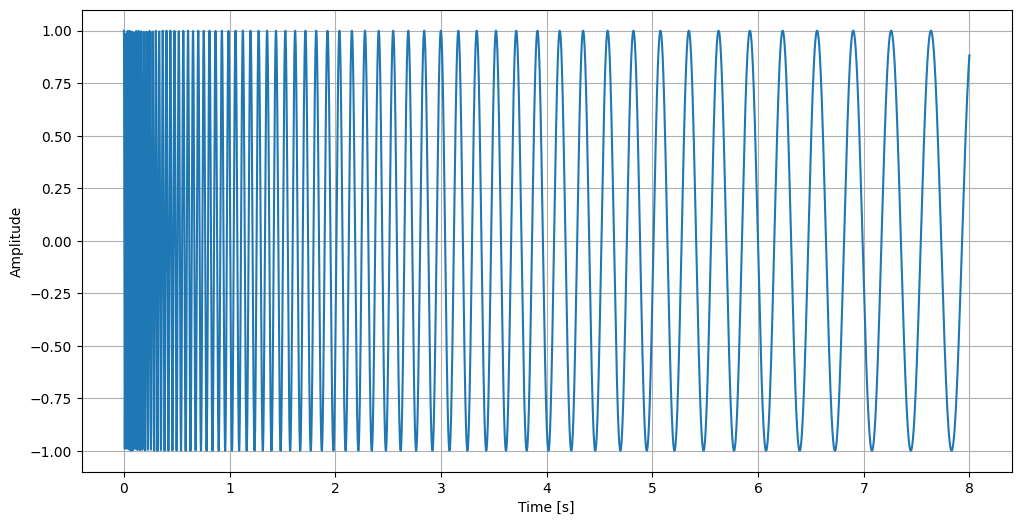

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, x)
plt.xlabel("Time [s]")
plt.ylabel(r"Amplitude")
plt.grid()
plt.show()

#### Computing your first orthogonal wavelet transform
The function `pywt.dwt` computes the wavelet transform for a single decomposition level, returning the corresponding approximation coefficients and details.

In [ ]:
cA, cD = pywt.dwt(x, "sym8")

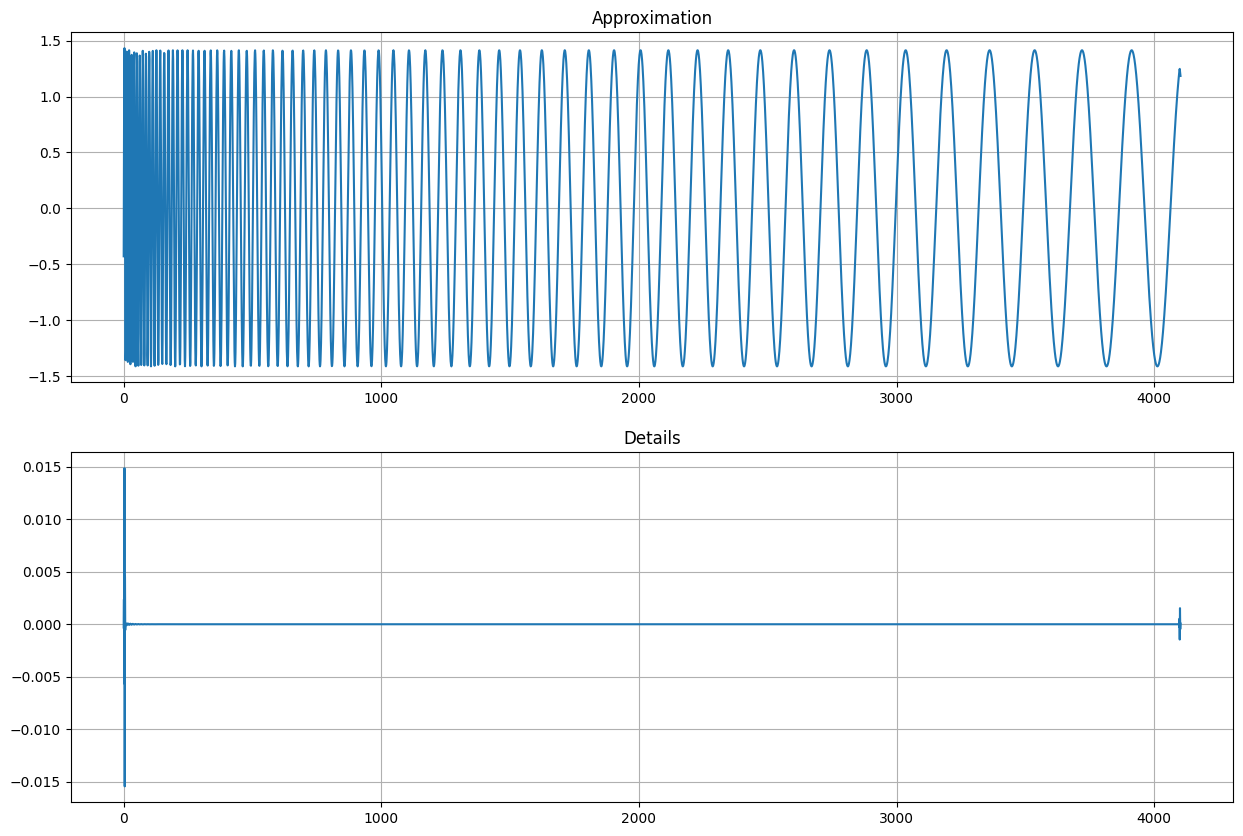

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(cA)
plt.title("Approximation")
plt.grid()
plt.subplot(212)
plt.plot(cD)
plt.title("Details")
plt.grid()
plt.show()

The `pywt.wavedec` function computes a multi-level wavelet transform. It returns an ordered list of coefficients arrays, where `level` denotes the number of decomposition levels. Wavelet coefficients are stored in an object `coeff`. The first element `coeff[0]` is an array containing approximation coefficients. The following elements `coeff[i]` are arrays containing the details coefficients at the different scales.

In [ ]:
coeff = pywt.wavedec(x, "sym8", level=7)

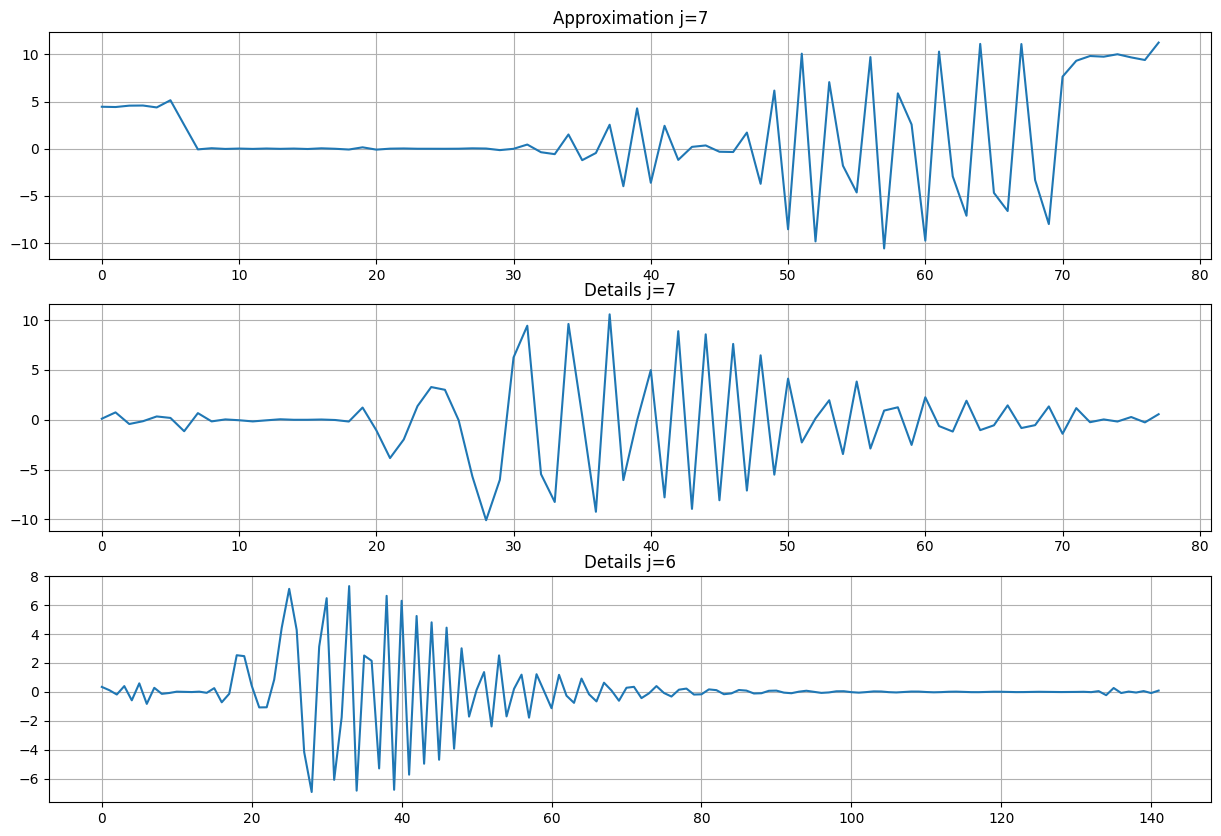

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.plot(coeff[0])
plt.title("Approximation j=7")
plt.grid()
plt.subplot(312)
plt.plot(coeff[1])
plt.title("Details j=7")
plt.grid()
plt.subplot(313)
plt.plot(coeff[2])
plt.title("Details j=6")
plt.grid()
plt.show()

### Exercise 1 <a id="ex1"></a> [(&#8593;)](#content)
1. Read the documentation of the functions `pywt.dwt`, `pywt.idwt` and `pywt.wavedec`. What are these functions used for? What is the difference between these functions?
2. The smallest scales can be filtered out by setting the associated wavelet coefficients to zero. Illustrate the effect of nulling some coefficients of the details (or the approximation) for a given set of octaves.
_Indication: to do this, you need to compute the wavelet transform, set some coefficients to zero and then reconstruct the signal by using the inverse wavelet transform._
3. Try this filtering operation with several wavelets of your choice and compare the results. Observe and comment.
4. Use at least one other 1D signal using `pywt.data`, and repeat the operations described in 2. and 3.

**Answers**
1. "pywt.dwt" performs a one-level discrete wavelet transform whereas "pywt.wavedec" performs a multi-level discrete wavelet transform of a signal, both functions provide approximation and detail coefficients. "pywt.idwt" performs a one-level inverse discrete wavelet transform, it reconstructs the signal with the approxilmation and detail coefficients provided.

In [ ]:
# 2.

N = 2 ** 13
Fs = 1024  # 2**10
t = np.arange(0, N, 1) / Fs
x = chirp(t, f0=60, f1=2, t1=10, method="hyperbolic")

cA, cD = pywt.dwt(x, "sym8") #compute the wavelet transform

for i in range (len(cA)//2):
    cA[2*i]=0 # set half the approximation coefficients to zero

y = pywt.idwt(cA, cD, "sym8")

Audio(y, rate=Fs*44, autoplay=True) # artificial change of Fs for listening

2. Computing the wavelet transform of a signal, replacing wavelet coefficients by zeros and then reconstructing the signal from the wavelet coefficients is indeed a way of altering the original signal (cf. cell above)

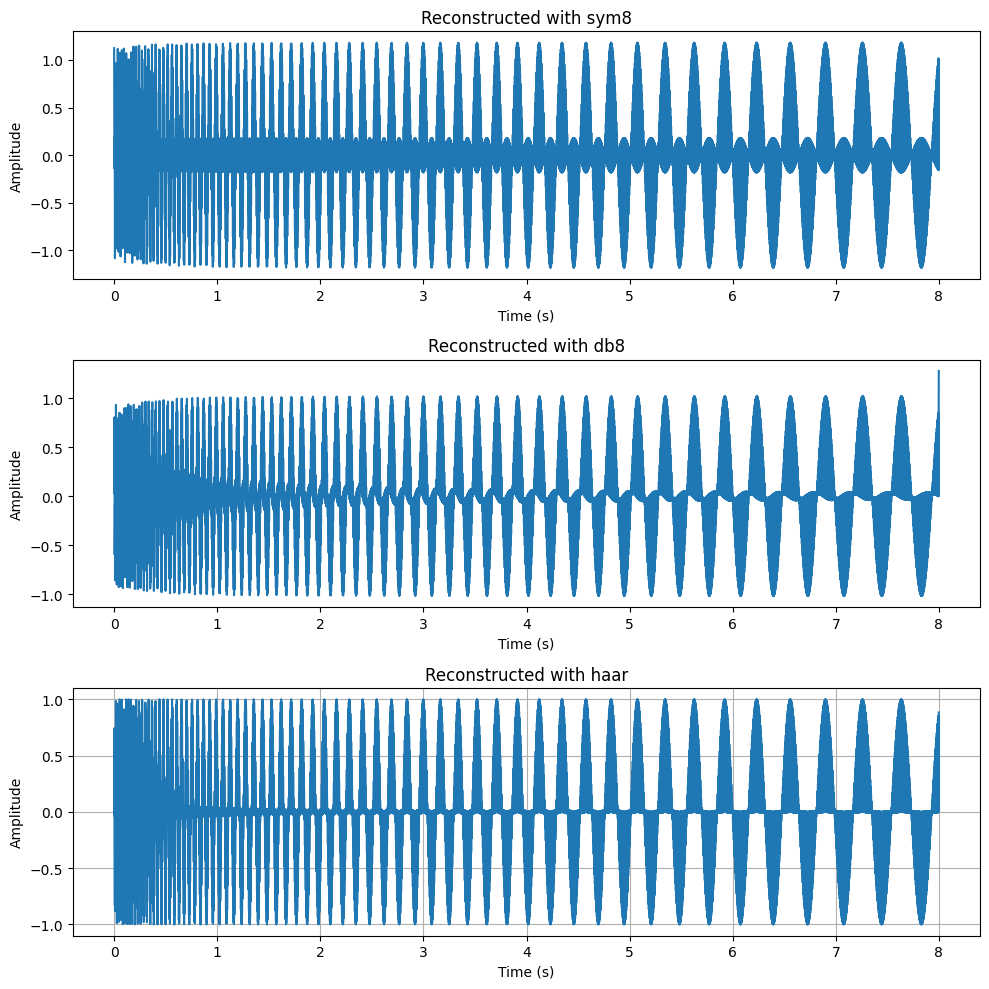

In [ ]:
# 3.

def filter(signal, wavelet): #set half the approximation coefficients to zero
  cA, cD = pywt.dwt(signal, wavelet)
  for i in range (len(cA)//2):
    cA[2*i]=0
  y = pywt.idwt(cA, cD, wavelet)
  return y

def compare(signal, wavelets): #plot reconstructed signals
  n = len(wavelets)
  fig, axs = plt.subplots(n, figsize=(10,10))
  for i in range(n):
    y = filter(signal, wavelets[i])
    axs[i].plot(t, y)
    axs[i].set_title("Reconstructed with " + wavelets[i])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Amplitude")
  plt.grid()
  fig.tight_layout()
  plt.show()

W = ["sym8","db8","haar"] #compare signals reconstructed with different wavelets

compare(x, W)

In [ ]:
# 4.

x2 = pywt.data.demo_signal('Doppler', N)

Audio(x2, rate=Fs*44, autoplay=True)

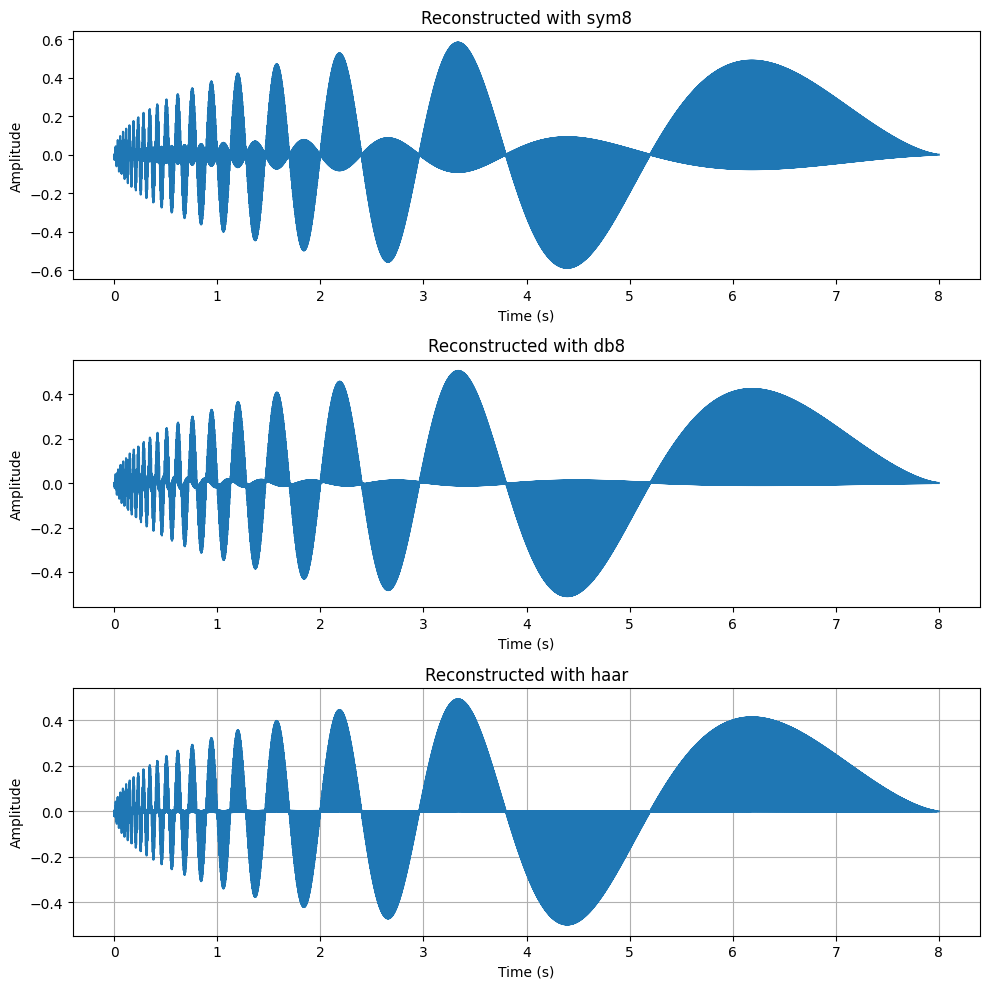

In [ ]:
compare(x2, W)

---
## 2D discrete wavelet transform <a id="section2"></a> [(&#8593;)](#content)
We now turn to the computation of a 2D wavelet transform to analyze images (example images are available in the `img/` folder). Let us start with a simple chessboard image.

_Indication: you can consider other images, in particular using `pywt.data`._

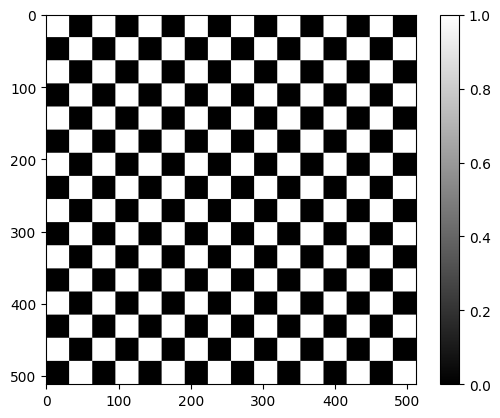

In [ ]:
filename = "/content/chessboard.png"

I = mpimg.imread(filename)

plt.figure()
plt.imshow(I, cmap="gray")
plt.colorbar()
plt.show()

#### Wavelet transform
We first compute a 2D wavelet transform using the function `pywt.wavedec2` and display the results.

Since the coefficients are stored in a dictionary of objects, we need to convert these into an array for obtain a graphical representation using the `plot_wavelet` function.

In [ ]:
def decomp_2D(Image, J, wavelet) :

  x = Image.astype(np.float32)
  shape = x.shape

  plt.figure(figsize=[6, 6])

  # compute the 2D DWT
  c = pywt.wavedec2(x, wavelet, mode='periodization', level=J)
  # normalize each coefficient array independently for better visibility
  c[0] /= np.abs(c[0]).max()
  for detail_level in range(J):
      c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
  # show the normalized coefficients
  arr, slices = pywt.coeffs_to_array(c)
  plt.imshow(arr, cmap=plt.cm.gray)
  plt.title('Coefficients\n({} level)'.format(J))
  plt.axis('off')

  plt.tight_layout()
  plt.show()

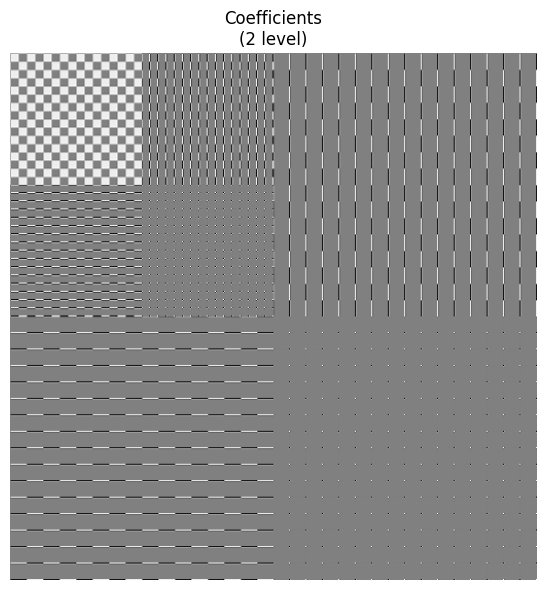

In [ ]:
decomp_2D(I, 2, "db2")

### Exercise 2 <a id="ex2"></a> [(&#8593;)](#content)
1. Observe the figure above and briefly recall its structure and what it represents.
2. Play with the parameter $J$ (corresponding to the optional parameter `level` from `pywt.wavedec2`). What does it correspond to?
3. Observe the wavelet transform of other images.
4. For the checkerboard image, try the Haar wavelet and compare the result with any other wavelet transform. What do you notice? Do you have an explanation?

**Answers**

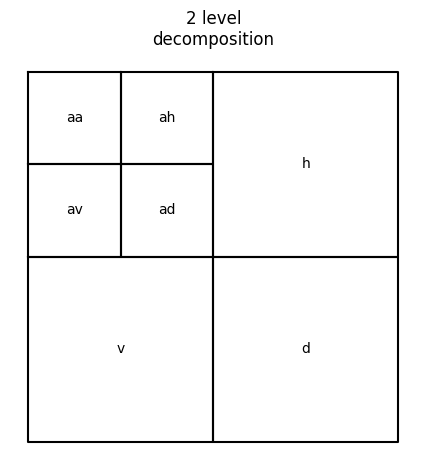

In [ ]:
# 1.

x = I.astype(np.float32)
shape = x.shape
J = 2

draw_2d_wp_basis(shape, wavedec2_keys(J),
                     label_levels=J)

plt.title('{} level\ndecomposition'.format(J))
plt.tight_layout()
plt.show()

1. The above figure is a common representation for multi-level 2D wavelet transform (2-level in this example). The respresentation is divided in 4 equally-sized squares. All of them except the top-left contain detail coefficients of the first decomposition. The bottom-right contain diagonal detail coefficients, the bottom-left contain vertical detail coefficients and the top-right contain horizontal detail coefficients. The top-left square is different from the others because itself divided in 4 equally-sized squares. All of them except the top-left contain detail coefficients of the second decomposition. The bottom-right contain diagonal detail coefficients, the bottom-left contain vertical detail coefficients and the top-right contain horizontal detail coefficients. In this example, this is only a 2-level decomposition. Thus, the remaining top-left square contain the approximation coefficients of the second decomposition. In an n-level decomposition. The previous mecanism of successive subdivisions ot the top-left square happens n times (cf. cell above).

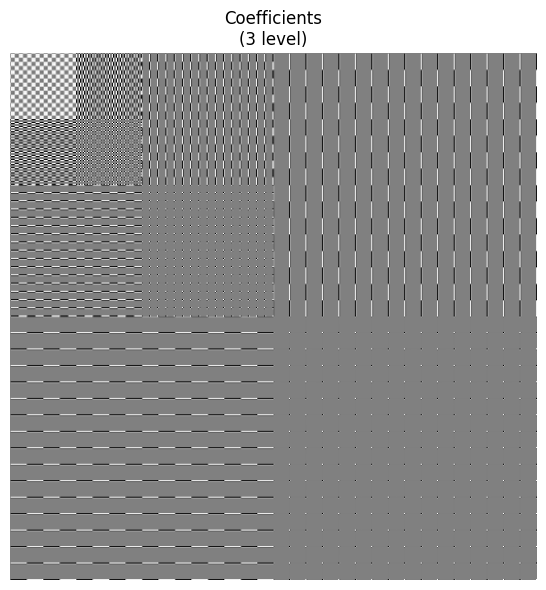

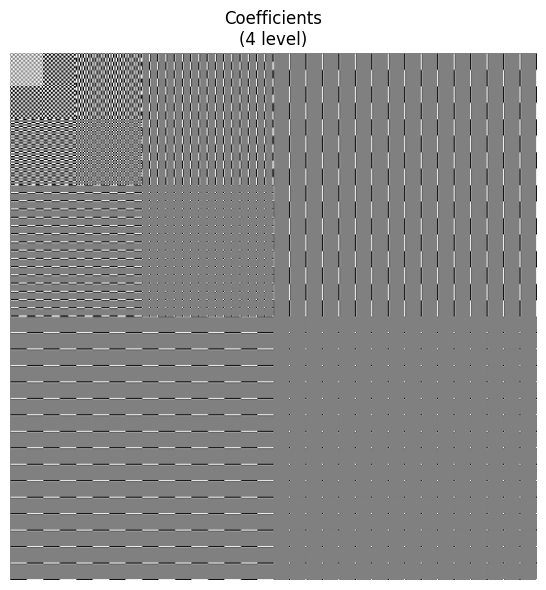

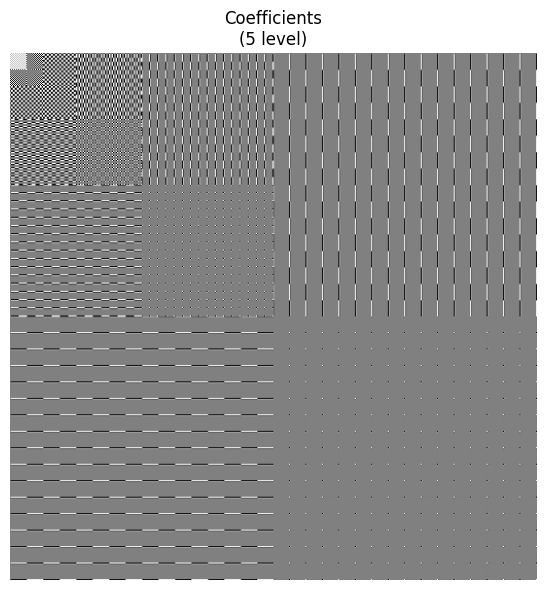

In [ ]:
# 2.

decomp_2D(I,3, "db2")
decomp_2D(I,4, "db2")
decomp_2D(I,5, "db2")

2. J is the level of decomposition

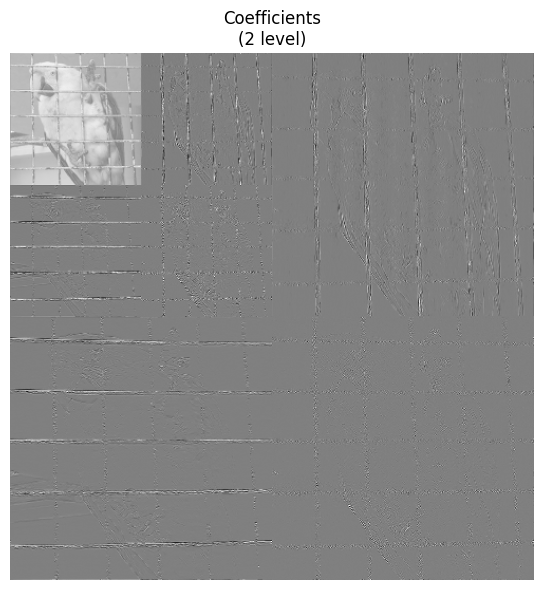

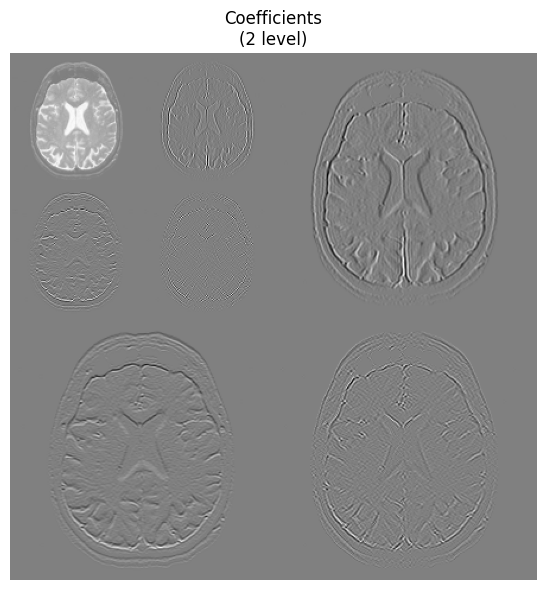

In [ ]:
# 3.

I_parrot = mpimg.imread("/content/parrot.png")
I_cortex = mpimg.imread("/content/cortex.png")

decomp_2D(I_parrot,2, "db2")
decomp_2D(I_cortex,2, "db2")

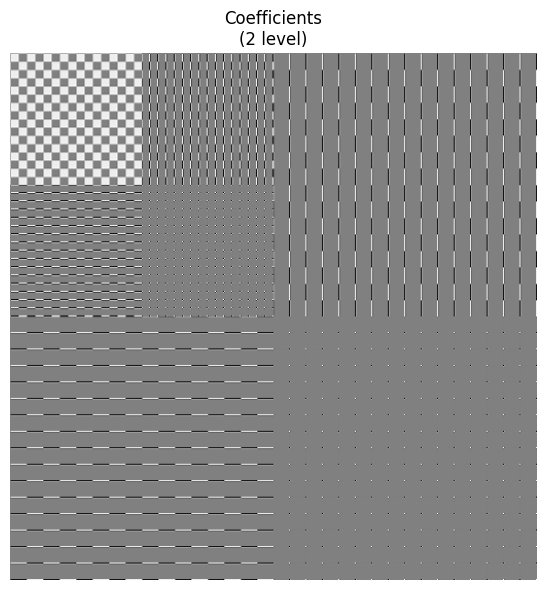

<ipython-input-16-9fddda96ce62>:13: RuntimeWarning: invalid value encountered in divide
  c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]


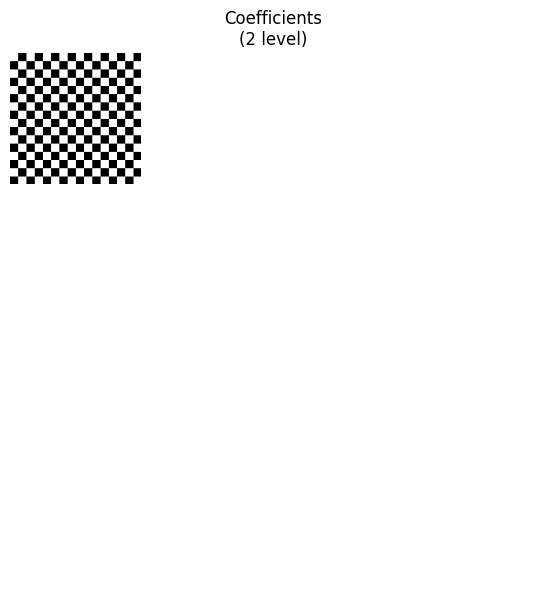

In [ ]:
#4.

decomp_2D(I, 2, "db2")
decomp_2D(I, 2, "haar")

4. The Haar wavelet gives particular results with the chessboard image. Indeed, the Haar wavelet perfectly matches the sharply alterning black and white squares of the image. Thus, the approximation coefficients of the decomposition catch all the information contained in this image, no matter the level of decomposition J. Every detail coefficients are null (cf. cell above).

---
## Wavelet filtering <a id="section3"></a> [(&#8593;)](#content)
This section illustrates a filtering procedure conducted in the wavelet domain. The purpose is to observe that one can filter an image both at a given scale, for specific orientations, and at chosen places on top.

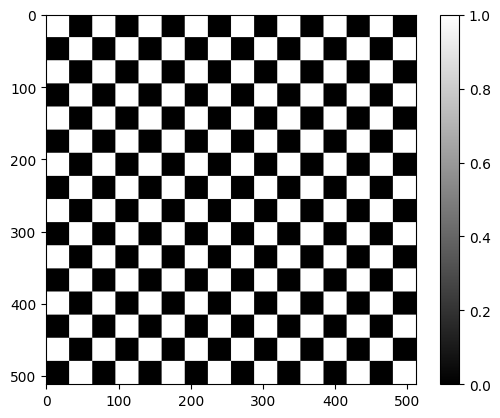

In [ ]:
filename = "/content/chessboard.png"
I = mpimg.imread(filename)


plt.figure()
plt.imshow(I, cmap="gray")
plt.colorbar()
plt.show()

#### First steps for filtering
We will first use a 1 step decomposition and put some coefficients to zero.

In [ ]:
coeffs2 = pywt.dwt2(I, "db4")

In [ ]:
LL, (LH, HL, HH) = coeffs2

In [ ]:
L = 8
LL[2 ** (L - 1) : 2 ** L + 1, 2 ** (L - 1) : 2 ** L + 1] = 0

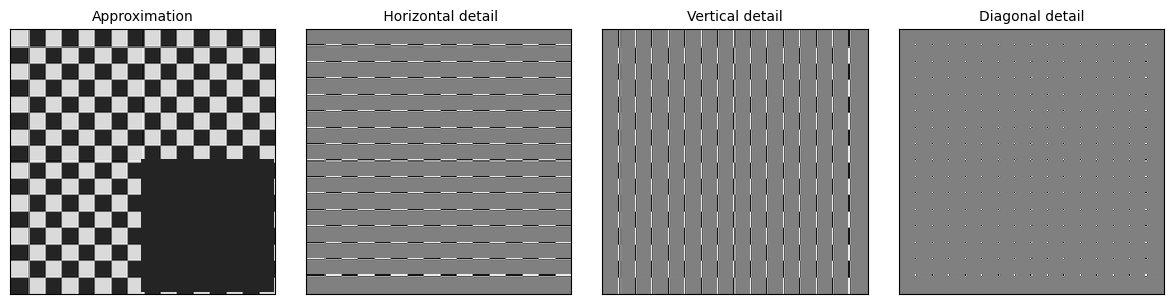

In [ ]:
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
titles = ["Approximation", " Horizontal detail", "Vertical detail", "Diagonal detail"]
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

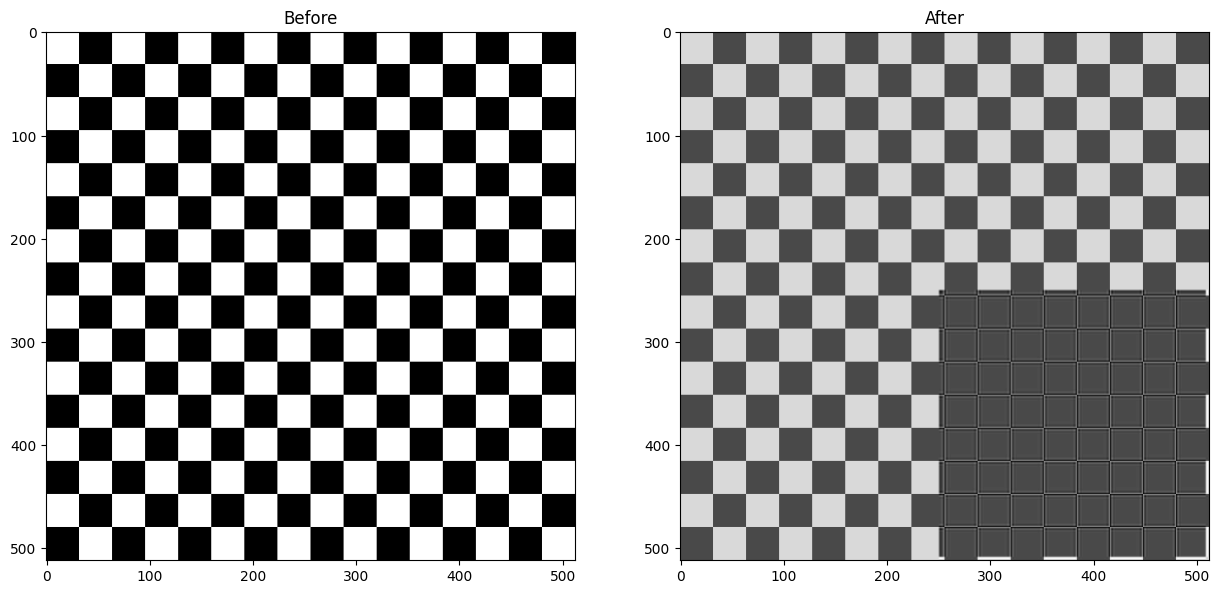

In [ ]:
I_d = pywt.idwt2(coeffs2, "db4")
fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray")
plt.title("Before")
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_d, cmap="gray")
plt.title("After")
# plt.colorbar()
plt.show()

### Exercise 3 <a id="ex3"></a> [(&#8593;)](#content)
1. Read the documentation of the `pywt.wavedec2` and `pywt.waverec2` functions to understand how to easily access any set of coefficients for a given scale and orientation.
2. Play with wavelet filtering procedure described above by setting some sets of coefficients to zero (approximation or details of various orientations). Illustrate its result with the `chessboard.png` image.
3. Do the same with any gray level image of your choice.
4. Observe and comment.

**Answers**

1. "pywt.wavedec2" is a multilevel 2D discrete wavelet transform. It returns the n-level approximation coefficient (cAn) and tuples (cHi, cVi, cDi), respectively horizontal, vertical and diagonal detail coefficients for level i, with i from 1 to n. The order of the returned coefficients is : {cAn, (cHn,cVn,cDn),(cH(n-1),cV(n-1),cD(n-1)),...,(cH1,cV1,cD1)}. "pywt.waverec2" is a multilevel 2D inverse discrete wavelet transform. With a list of coefficients such as the list returned by "pywt.wavedec2" as input, "pywt.waverec2" returns a 2D array.

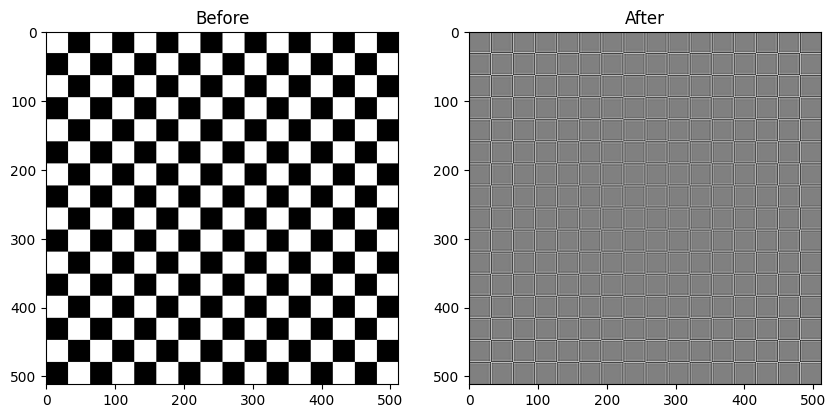

In [ ]:
# 2.

filename = "/content/chessboard.png"
I = mpimg.imread(filename)

coeffs2 = pywt.dwt2(I, "db4") # wavelet transform

LL, (LH, HL, HH) = coeffs2

for i in range(len(LL)):
    LL[i]=0 # Replace half the approximation coefficients with zeros

I_d = pywt.idwt2(coeffs2, "db4")
fig = plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray")
plt.title("Before")
plt.subplot(122)
plt.imshow(I_d, cmap="gray")
plt.title("After")
plt.show()

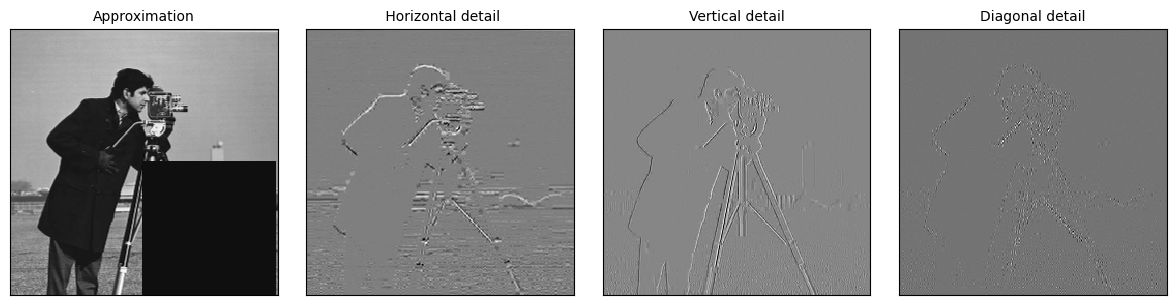

In [ ]:
# 3.

filename = "/content/cameraman.png"
I = mpimg.imread(filename)

coeffs2 = pywt.dwt2(I, "db4")

LL, (LH, HL, HH) = coeffs2

L = 8
LL[2 ** (L - 1) : 2 ** L + 1, 2 ** (L - 1) : 2 ** L + 1] = 0

LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
titles = ["Approximation", " Horizontal detail", "Vertical detail", "Diagonal detail"]
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

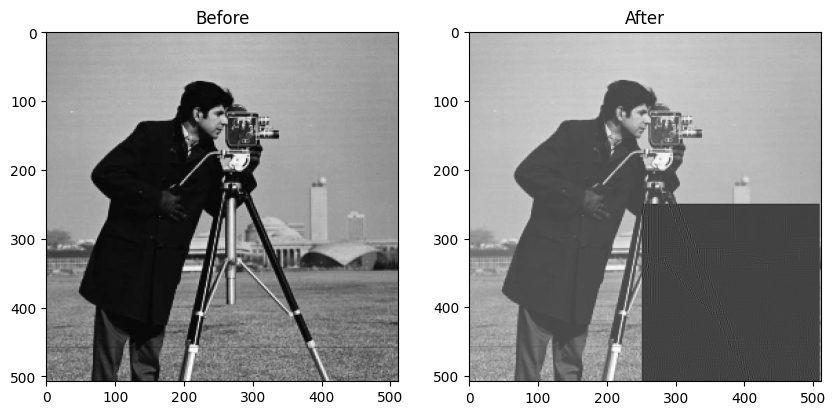

In [ ]:
I_d = pywt.idwt2(coeffs2, "db4")
fig = plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray")
plt.title("Before")
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_d, cmap="gray")
plt.title("After")
# plt.colorbar()
plt.show()

4. On the chessboard image, every approximation is set to zero before reconstructing the signal with the inverse wavelet transform. The reconstructed image does not look like the original. The detail coefficients help reconstruct the grid pattern however, the squares are now all grey. On the cameraman image, a quarter of the approximation coefficients are set to zero. It causes a very low contrast zone on the bottom-right of the image, which has been reconstructed only with the details coefficients.

---
## Wavelet Denoising <a id="section4"></a> [(&#8593;)](#content)

Wavelets are suitable for denoising signals which contain fast transients. In this context, thresholding can be used to cancel out the wavelet coefficients corresponding to regions where the signal varies smoothly. In these regions, the coefficients are expected to remain small (denoising is then provided by the low-pass cascade), and large wavelet coefficients (corresponding to large and fast transients of the signal) are preserved.

Let's simulate a noisy image to test the denoising procedure described above.

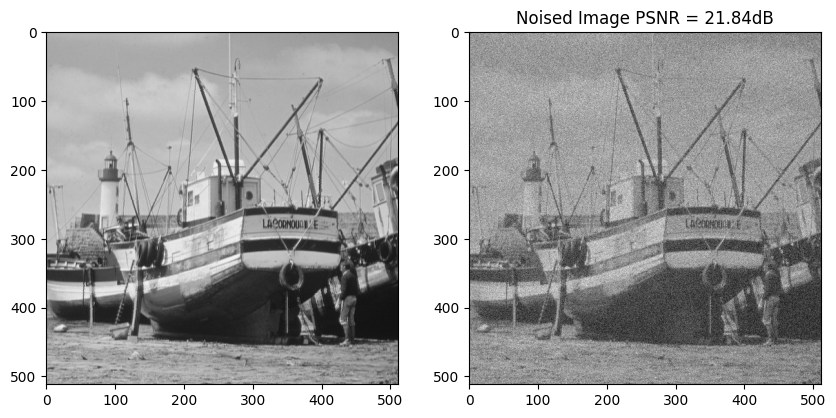

In [ ]:
# The original image
filename = "/content/boat.png"
I = mpimg.imread(filename)

I = I[:, :]

# The noise
sigma = 0.1  # noise level

[n, m] = I.shape
noise = np.random.randn(n, m) * sigma

# The noisy image
I_noisy = I + noise

#PSNR definition
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = max(I.max(),I_noisy.max())
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# The PSNR quantifies the level of noise (see below for more explanations)
psnr1 = PSNR(I, I_noisy)


# Graphical representation
fig = plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray")
plt.subplot(122)
plt.imshow(I_noisy, cmap="gray")
plt.title("Noised Image PSNR = {}dB".format(np.round(psnr1,2)))
plt.show()

#### Peak signal-to-noise ratio: definition
The peak signal-to-noise ratio (PSNR) is defined as the ratio between the maximum possible power of a signal and the power of the noise that affecting its representation. Since many signals have a very wide dynamic range, the PSNR is usually expressed in decibel scale (dB).

The PSNR is usually defined via the mean squared error (MSE). Given a noise-free $m \times n$ monochromatic image $I$ and its noisy approximation $K$, the MSE is defined as:

$$\mathrm{MSE} = \frac{1}{m\,n}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1} [I(i,j) - K(i,j)]^2 = \frac{1}{m\,n} \|I - K \|^2_{\text{F}}.$$

The PSNR in decibel (dB) is defined as:

\begin{align}
\mathrm{PSNR} &= 10 \log_{10} \left( \frac{\mathrm{MAX}_I^2}{\mathrm{MSE}} \right)\\
    &= 20 \log_{10} \left( {\mathrm{MAX}_I} \right) - 10 \log_{10} \left( {{\mathrm{MSE}}} \right)
\end{align}

where $\mathrm{MAX}_I$ corresponds to the maximum possible value taken by a pixel of the image. When the pixels are represented using 8 bits per sample, this is 255. The lower the error, the higher the PSNR.

**Extension to color images**: for color images, with containing three values per pixel (RGB representation), the definition of the PSNR is the similar, except the MSE is the sum over all squared value differences (for each color, i.e. three times as many values as in a monochromatic image) divided by 3 times the image size.

#### Thresholding
You can either use the `pywt.threshold` function, or a custom function as implemented below:

In [ ]:
def perform_hardthresholding(f, thres):
    return f * (abs(f) > thres)

In [ ]:
# Wavelet decomposition
Jmax = int(np.log2(I_noisy.shape[0]))  # maximal number of octaves
J = 5

coeffs = pywt.wavedec2(I_noisy, wavelet="sym8", level=J, mode="periodization")

# Conversion to an array
coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)

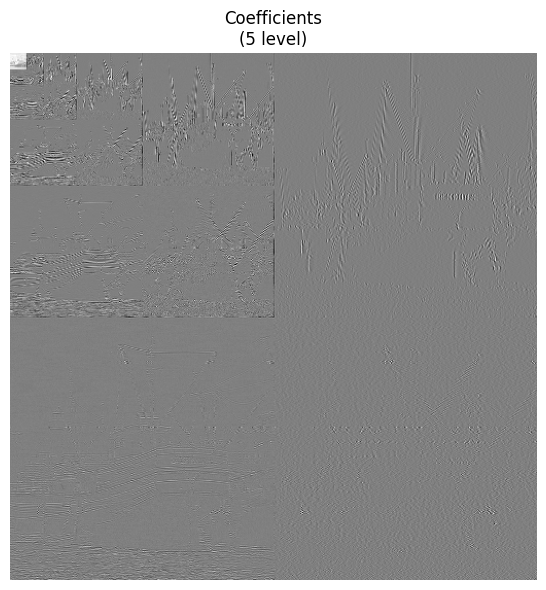

In [ ]:
decomp_2D(I, 5, "sym8")

In the following, we will keep the approximation coefficients unchanged, and only threshold details coefficients. Futher indications are provided below.

In [ ]:
# Thresholding detail coefficients only (while preserving approximation coefficients)

thres = 2.0 * sigma
coeffs_arr_hard = perform_hardthresholding(coeffs_array, thres)

In [ ]:
# convert the array of coeffcients to pywt coeffs
coeffs_hard = pywt.array_to_coeffs(coeffs_arr_hard, coeff_slices)

# Setting original approximation coefficients back
coeffs_hard[0] = coeffs[0]  # approximation preserved

In [ ]:
# Back to an array for graphical representation
coeffs_hard_arr, slices = pywt.coeffs_to_array(coeffs_hard)

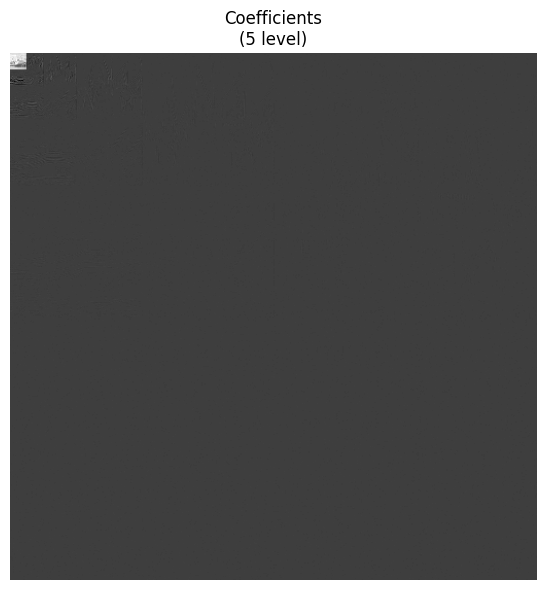

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(coeffs_hard_arr, cmap=plt.cm.gray)
plt.title('Coefficients\n({} level)'.format(J))
plt.axis('off')

plt.tight_layout()
plt.show()

#### Reconstruction

In [ ]:
I_den = pywt.waverecn(
    coeffs_hard, "sym8", mode="periodization")  # Multilevel n-dimensional Inverse Discrete Wavelet Transform

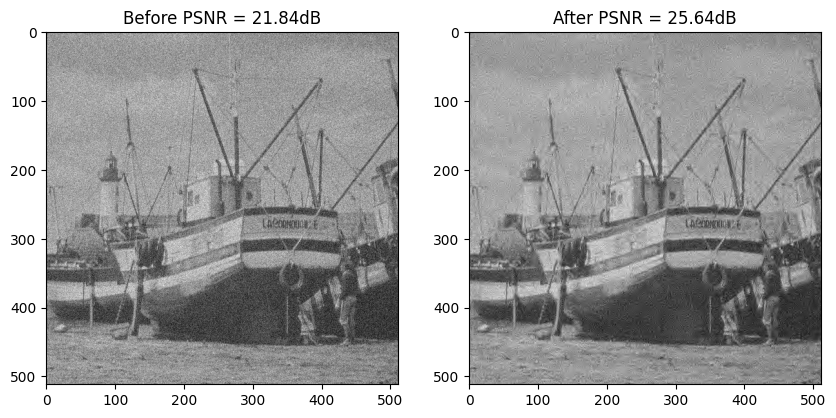

In [ ]:
psnr2 = PSNR(I, I_den)
plt.fig = plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(I_noisy, cmap="gray")
plt.title("Before PSNR = {}dB".format(np.round(psnr1,2)))
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_den, cmap="gray")
plt.title("After PSNR = {}dB".format(np.round(psnr2,2)))
# plt.colorbar()
plt.show()

### Exercise 4 <a id="ex4"></a> [(&#8593;)](#content)
1. Observe the effect of the level of the decomposition and of the threshold.
2. Optimize the parameters of your wavelet denoising strategy to get the best possible PSNR.

**Answers**

In [ ]:
# 1.

def denoising(thres, J, wavelet) :

  # Wavelet decomposition
  Jmax = int(np.log2(I_noisy.shape[0]))  # maximal number of octaves

  coeffs = pywt.wavedec2(I_noisy, wavelet=wavelet, level=J, mode="periodization")

  # Conversion to an array
  coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)

  # Thresholding detail coefficients only (while preserving approximation coefficients)
  # 1) threshold all coefficients stored in an array
  # 2) reset approx coefficients to their original value

  coeffs_arr_hard = perform_hardthresholding(coeffs_array, thres)

  # convert the array of coeffcients to pywt coeffs
  coeffs_hard = pywt.array_to_coeffs(coeffs_arr_hard, coeff_slices)

  # Setting original approximation coefficients back
  coeffs_hard[0] = coeffs[0]  # approximation preserved

  # Back to an array for graphical representation
  coeffs_hard_arr, slices = pywt.coeffs_to_array(coeffs_hard)

  I_den = pywt.waverecn(
      coeffs_hard, wavelet, mode="periodization"
  )  # Multilevel n-dimensional Inverse Discrete Wavelet Transform

  psnr2 = PSNR(I, I_den)
  return round(psnr2-psnr1,2)

In [ ]:
def denoising_plot(thres, J, wavelet) :

  # Wavelet decomposition
  Jmax = int(np.log2(I_noisy.shape[0]))  # maximal number of octaves

  coeffs = pywt.wavedec2(I_noisy, wavelet=wavelet, level=J, mode="periodization")

  # Conversion to an array
  coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)

  # Thresholding detail coefficients only (while preserving approximation coefficients)
  # 1) threshold all coefficients stored in an array
  # 2) reset approx coefficients to their original value

  coeffs_arr_hard = perform_hardthresholding(coeffs_array, thres)

  # convert the array of coeffcients to pywt coeffs
  coeffs_hard = pywt.array_to_coeffs(coeffs_arr_hard, coeff_slices)

  # Setting original approximation coefficients back
  coeffs_hard[0] = coeffs[0]  # approximation preserved

  # Back to an array for graphical representation
  coeffs_hard_arr, slices = pywt.coeffs_to_array(coeffs_hard)

  I_den = pywt.waverecn(
      coeffs_hard, wavelet, mode="periodization"
  )  # Multilevel n-dimensional Inverse Discrete Wavelet Transform

  psnr2 = PSNR(I, I_den)
  plt.fig = plt.figure(figsize=(10, 7))
  plt.subplot(121)
  plt.imshow(I_noisy, cmap="gray")
  plt.title("Before PSNR = {}dB".format(round(psnr1,2)))
  # plt.colorbar()
  plt.subplot(122)
  plt.imshow(I_den, cmap="gray")
  plt.title("After PSNR = {}dB".format(round(psnr2,2)))
  # plt.colorbar()
  plt.show()
  print("PSNR decreased by : {} dB".format(round(psnr2-psnr1,2)))

In [ ]:
def optimizer(wavelet) :

  PSNR_increase = np.zeros((5,5))
  thres_factor = 1
  J = 1

  for i in range(5):
    for J in range(5):
      PSNR_increase[i][J] = denoising((i+1)*thres_factor*sigma, J+1, wavelet)

  # Labels
  xlabs = [str(i+1) for i in range(5)]
  ylabs = [str(i+1) for i in range(5)]

  # Heat map
  fig, ax = plt.subplots()
  ax.imshow(PSNR_increase)

  # Add the labels
  ax.set_xticks(np.arange(len(xlabs)), labels = xlabs)
  ax.set_yticks(np.arange(len(ylabs)), labels = ylabs)

  # Add the values to each cell
  for i in range(len(xlabs)):
      for j in range(len(ylabs)):
          text = ax.text(j, i, PSNR_increase[i, j], ha = "center", va = "center", color = "w")

  plt.xlabel("J")
  plt.ylabel("thres_factor")
  plt.title(wavelet)
  plt.show()

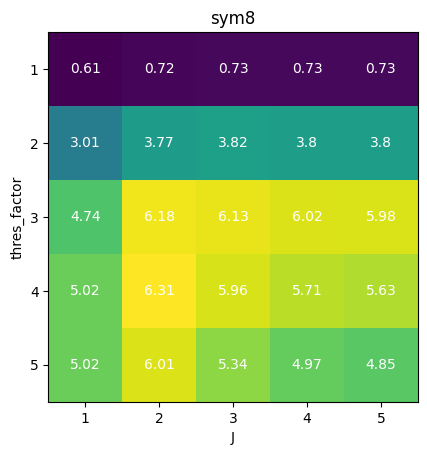

In [ ]:
optimizer("sym8")

1. J and the threshold have significant impact on the PSNR. To maximize the PSNR, the threshold should not be too high because it would eliminate too many coefficients for the reconstructed image to be similar to the original one. However, the threshold should not be too low because then the noise would not be filtered out enough. A similar logic applies to the level of the decomposition. For a fixed threshold, if J is too low, then the noise is not filtered out enough. However, over a certain value of J, its increase does not change the PSNR very much (cf. code above).

In [ ]:
# 2.

pywt.wavelist() # list of wavelets

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

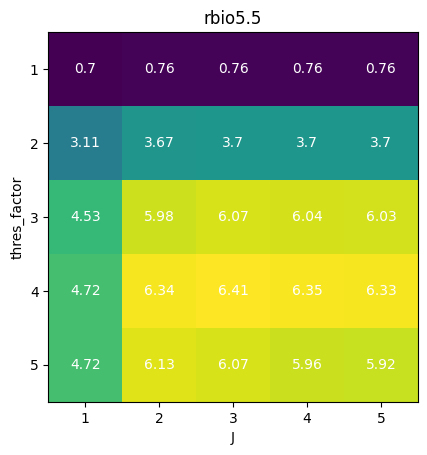

In [ ]:
optimizer("rbio5.5")

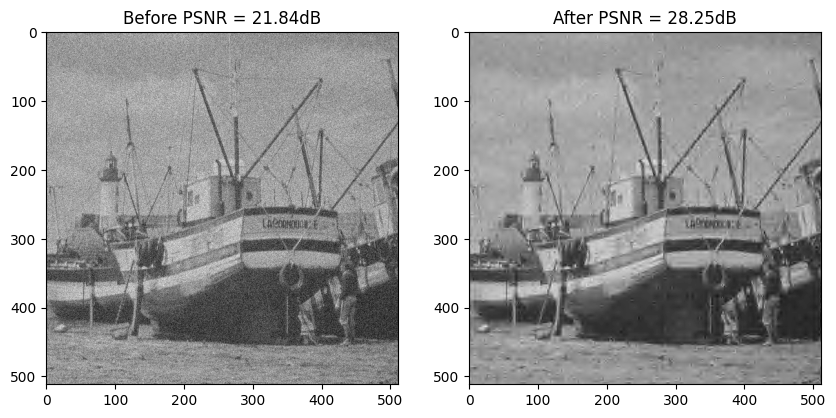

PSNR decreased by : 6.41 dB


In [ ]:
denoising_plot(4*sigma, 3, "rbio5.5" )

2. After performing this denoising operation with different wavelets and searching the optimal value of the threshold and of J to maximize the PSNR, the "rbio5.5" offers the best PSNR increase with more than 6 dB. This maximum PSNR increase is obtained for a treshold of 0.4 and a level of decomposition J=3 (cf. code above).